<a href="https://colab.research.google.com/github/aigonna/nlp-tutorial/blob/main/2_disaster_and_nondisaster_tweets_electra_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Sep  9 06:10:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!mkdir /root/.kaggle/
!cp /content/drive/MyDrive/kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c nlp-getting-started -p /content/drive/Shareddrives/all/nlp

  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 3.36MB/s]
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 27.4MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 64.5MB/s]


In [5]:
!cp -r /content/drive/Shareddrives/all/nlp/data /content/
os.chdir('/content/data')

In [6]:
import torch
if torch.cuda.is_available():  
    device = torch.device("cuda")
    print('I will use the GPU:', torch.cuda.get_device_name(0))
    
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

I will use the GPU: Tesla P100-PCIE-16GB


## 1.数据预处理

In [74]:
import re
import torch
import numpy as np
import pandas as pd
import random, time, datetime
import matplotlib.pyplot as plt
from  pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import TensorDataset, DataLoader,\
            RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup

In [9]:
data_dir = Path('/content/data')
train = pd.read_csv(data_dir/'train.csv')
test = pd.read_csv(data_dir/'test.csv')

train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
def preprocess(text):
    """预处理小写, 去除超链接 奇怪字符 以及 非ASCII 标点符等"""
    text = text.lower()
    # remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'http?:\/\/.*[\r\n]*', '', text)
    # Replace &amp, &lt, &gt with &,<,> respectively
    text = text.replace(r'&amp;?', r'and')
    text = text.replace(r'&lt;', r'<')
    text = text.replace(r'&gt;', r'>')
    # remove hashtag sign
    # text=re.sub(r"#","",text)
    # remove mentions
    text = re.sub(r"(?:\@)\w+", '', text)
    # text=re.sub(r"@","",text)
    # remove non ascii chars
    text = text.encode("ascii", errors="ignore").decode()
    # remove some puncts (except . ! ?)
    text = re.sub(r'[:"#$%&\*+,-/:;<=>@\\^_`{|}~]+', '', text)
    text = re.sub(r'[!]+', '!', text)
    text = re.sub(r'[?]+', '?', text)
    text = re.sub(r'[.]+', '.', text)
    text = re.sub(r"'", "", text)
    text = re.sub(r"\(", "", text)
    text = re.sub(r"\)", "", text)

    text = " ".join(text.split())
    return text

In [13]:
train['text'] = train['text'].apply(preprocess)
test['text'] = test['text'].apply(preprocess)
train = train[train['text'] != '']
train = train[['text', 'target']]
train.head()

,text,target
0,our deeds are the reason of this earthquake ma...,1
1,forest fire near la ronge sask canada,1
2,all residents asked to shelter in place are be...,1
3,13000 people receive wildfires evacuation orde...,1
4,just got sent this photo from ruby alaska as s...,1


In [16]:
train['target'].value_counts() #看看正负样本均衡吗

0    4314
1    3247
Name: target, dtype: int64

In [ ]:
!pip install transformers

##获取token

In [20]:
from transformers import ElectraTokenizer, ElectraForSequenceClassification, AdamW
tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/666 [00:00<?, ?B/s]

In [21]:
model = ElectraForSequenceClassification.from_pretrained('google/electra-base-discriminator', num_labels=2)
model.cuda()

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.o

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [32]:
def plt_sentence_embeddings_length(text_list, tokenizer):
    """绘制tokenized text长度和数目关系直方图"""
    #传入文本tokenizer.tokenize(t) 所有list
    tokenizer_texts = list(map(lambda  t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda  t: len(t), tokenizer_texts))
    
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.hist(tokenized_texts_len, bins=40)
    ax.set_xlabel('Length of Comment Embeddings')
    ax.set_ylabel('Number of Comments')
    return 

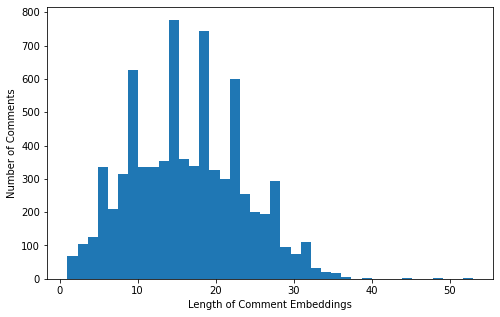

In [33]:
texts = train.text.values
labels = train.target.values
plt_sentence_embeddings_length(texts, tokenizer)

- 一些token ids转换示例
- [attention-mask](https://huggingface.co/transformers/glossary.html#attention-mask)

In [36]:
from transformers import BertTokenizer


string = 'encode decode bert transformers.'

t = BertTokenizer.from_pretrained('./bert-base-uncased', bos_token='[BOS]', eos_token='[EOS]')

tokens = t.tokenize(string)
ids = t.convert_tokens_to_ids(tokens)

print(tokens)  # ['en', '##code', 'deco', '##de', 'bert', 'transformers', '.']
print(ids)  # [4372, 16044, 21933, 3207, 14324, 19081, 1012]

print(t.tokenize(string))  # ['en', '##code', 'deco', '##de', 'bert', 'transformers', '.']
print(t.convert_tokens_to_string(tokens))  # encode decode bert transformers .

print(t.convert_ids_to_tokens(ids))  # ['en', '##code', 'deco', '##de', 'bert', 'transformers', '.']
print(t.convert_tokens_to_ids(tokens))  # [4372, 16044, 21933, 3207, 14324, 19081, 1012]



print(t.encode(string))  # [101, 4372, 16044, 21933, 3207, 14324, 19081, 1012, 102]
print(t.decode(ids))  # encode decode bert transformers.


#注意：encode 默认会添加 special token，decode 默认不会跳过 special token
#要么 encode 设置 add_special_tokens=False，要么decode 设置 skip_special_tokens=True
print(t.decode(t.encode(string)))  # '[CLS] encode decode bert transformers. [SEP]'



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['en', '##code', 'deco', '##de', 'bert', 'transformers', '.']
[4372, 16044, 21933, 3207, 14324, 19081, 1012]
['en', '##code', 'deco', '##de', 'bert', 'transformers', '.']
encode decode bert transformers .
['en', '##code', 'deco', '##de', 'bert', 'transformers', '.']
[4372, 16044, 21933, 3207, 14324, 19081, 1012]
[101, 4372, 16044, 21933, 3207, 14324, 19081, 1012, 102]
encode decode bert transformers.
[CLS] encode decode bert transformers. [SEP]


In [38]:
print(t.encode_plus(string))  
# {'input_ids': [101, 4372, 16044, 21933, 3207, 14324, 19081, 1012, 102], 
	# 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 
	# 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

strings = [string, string]
out = t.batch_encode_plus(strings)
print(out )
# {'input_ids': [[101, 4372, 16044, 21933, 3207, 14324, 19081, 1012, 102], 
#  [101, 4372, 16044, 21933, 3207, 14324, 19081, 1012, 102]],
# 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0], 0代表答案 1代表问题 还有2
# 				   [0, 0, 0, 0, 0, 0, 0, 0, 0]], 
# 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1], 1代表注意到
# 				   [1, 1, 1, 1, 1, 1, 1, 1, 1]]}

print(t.batch_decode(out.input_ids)) # 						
# ['[CLS] encode decode bert transformers. [SEP]', 
#  '[CLS] encode decode bert transformers. [SEP]']

{'input_ids': [101, 4372, 16044, 21933, 3207, 14324, 19081, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'input_ids': [[101, 4372, 16044, 21933, 3207, 14324, 19081, 1012, 102], [101, 4372, 16044, 21933, 3207, 14324, 19081, 1012, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1]]}
['[CLS] encode decode bert transformers. [SEP]', '[CLS] encode decode bert transformers. [SEP]']


In [42]:
#获取索引
indices = tokenizer.batch_encode_plus(texts, max_length=64,\
            add_special_tokens=True, return_attention_mask=True,\
            padding=True, truncation=True)


In [43]:
for i in indices: print(i)

input_ids
token_type_ids
attention_mask


In [46]:
input_ids = indices['input_ids']
attention_masks = indices['attention_mask']

In [49]:
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, random_state=2020, test_size=0.2)
train_masks, val_masks, _, _ = train_test_split(attention_masks, labels, random_state=2020, test_size=0.2)

In [50]:
#转tensor
train_inputs = torch.tensor(train_inputs)
val_inputs = torch.tensor(val_inputs)
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
train_masks = torch.tensor(train_masks)
val_masks = torch.tensor(val_masks)

In [54]:
batch_size = 64
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [55]:
optimizer = AdamW(model.parameters(), lr=6e-6, eps=1e-8) 

In [57]:
epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,\
                        num_training_steps=total_steps)


In [63]:
def flat_acc(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    """获取s级时间差返回hh:mm:ss str"""
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [65]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(2020)

In [71]:
loss_lists = []#loss列表
for epoch in range(0, epochs):
    print(f"Epoch {epoch} training!")
    t0 = time.time()
    total_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>2,} of {:>2,}. Elapsed:{:}'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None,
                attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]

        total_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)#梯度clip到1.0
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_loss / len(train_dataloader)
    loss_lists.append(avg_train_loss)
    print("Average training loss {0:.2f}".format(avg_train_loss))
    print("Epoch training took: {0:}".format(format_time(time.time() - t0)))
print("Training complete!")

Epoch 0 training!
Batch 50 of 95. Elapsed:0:00:17
Average training loss 0.40
Epoch training took: 0:00:32
Epoch 1 training!
Batch 50 of 95. Elapsed:0:00:17
Average training loss 0.39
Epoch training took: 0:00:32
Epoch 2 training!
Batch 50 of 95. Elapsed:0:00:17
Average training loss 0.37
Epoch training took: 0:00:32
Epoch 3 training!
Batch 50 of 95. Elapsed:0:00:17
Average training loss 0.38
Epoch training took: 0:00:32
Epoch 4 training!
Batch 50 of 95. Elapsed:0:00:17
Average training loss 0.37
Epoch training took: 0:00:32
Training complete!


In [73]:
#eval
print("Running Validation!")
t0 = time.time()
model.eval()

preds= []
true = []
eval_loss, eval_acc = 0, 0
#each batch steps/examples numbers
nb_eval_steps, nb_eval_examples = 0, 0

for batch in val_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask)
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    preds.append(logits)
    true.append(label_ids)
    
    #当前batch acc
    tmp_eval_acc = flat_acc(logits, label_ids)
    eval_acc += tmp_eval_acc
    nb_eval_steps += 1
print('Accuracy: {0:.2f}'.format(eval_acc/nb_eval_steps))
print('Validation took:{}'.format(format_time(time.time() - t0)))

Running Validation!
Accuracy: 0.83
Validation took:0:00:03


In [82]:
len(preds[1])

64

In [85]:
#将preds取出作为列表
flat_predictions = [item  for sublist in preds for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

In [86]:
flat_true_labels = [item for sublist in true for item in sublist]
print(classification_report(flat_predictions, flat_true_labels))

              precision    recall  f1-score   support

           0       0.88      0.83      0.85       904
           1       0.77      0.83      0.80       609

    accuracy                           0.83      1513
   macro avg       0.82      0.83      0.83      1513
weighted avg       0.83      0.83      0.83      1513



In [87]:
#拿test中评论文本预测
comments_t = test.text.values
indices_t = tokenizer.batch_encode_plus(comments_t, max_length=64,\
            add_special_tokens=True, return_attention_mask=True,\
            padding=True, truncation=True)

input_ids_t = indices_t['input_ids']
attention_masks_t = indices_t['attention_mask']
pred_inputs = torch.tensor(input_ids_t)
pred_masks = torch.tensor(attention_masks_t)

pred_data = TensorDataset(pred_inputs, pred_masks)
pred_sampler = SequentialSampler(pred_data)
pred_dataloader = DataLoader(pred_data, sampler=pred_sampler, batch_size=batch_size)

print("Predicting labels for {:,} test sentences...".format(len(pred_inputs)))
model.eval()
preds_t = []

for batch in pred_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids1, b_input_mask1 = batch
    with torch.no_grad():
        outputs1 = model(b_input_ids1, token_type_ids=None,
                        attention_mask=b_input_mask1)
    logits1 = outputs1[0]
    logits1 = logits1.detach().cpu().numpy()
    preds_t.append(logits1)

flat_predictions = [item for sublist in preds_t for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

Predicting labels for 3,263 test sentences...


In [88]:
sample_df = pd.read_csv(data_dir/'sample_submission.csv')
submit = pd.DataFrame({'id': sample_df['id'].values.tolist(), 'target': flat_predictions})
submit.to_csv('submission.csv', index=False)


In [89]:
# /content/data/submission.csv 0.82071
!kaggle competitions submit -c nlp-getting-started -f /content/data/submission.csv -m "sub"

100% 22.2k/22.2k [00:03<00:00, 6.55kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets